[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1oLm-r6os4gnWEB6JF2XQl5HRkOYuEPFd#scrollTo=TyGUIOoR3pvo)


# Imports

In [ ]:
!pip install nltk pymorphy2

In [ ]:
!pip install transformers

In [ ]:
import requests

In [ ]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image

In [ ]:
import nltk
from pymorphy2 import MorphAnalyzer

nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer

## Image to text generator

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
path_image2text = 'tuman/vit-rugpt2-image-captioning'

model = VisionEncoderDecoderModel.from_pretrained(path_image2text)
feature_extractor = ViTFeatureExtractor.from_pretrained(path_image2text)
tokenizer = AutoTokenizer.from_pretrained(path_image2text)
model.to(device)

In [ ]:
max_length = 20
num_beams = 4
temperature = 1.2
gen_kwargs = {"max_length": max_length, "num_beams": num_beams, 'temperature': temperature}

def predict_caption(url):

  image = Image.open(requests.get(url, stream=True).raw)

  pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds][0]
  return preds

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
url = "http://images.cocodataset.org/test-stuff2017/000000000619.jpg"

generated_caption = predict_caption(url)
print(generated_caption)

['Женщина сидит за столом с кучей бананов.']


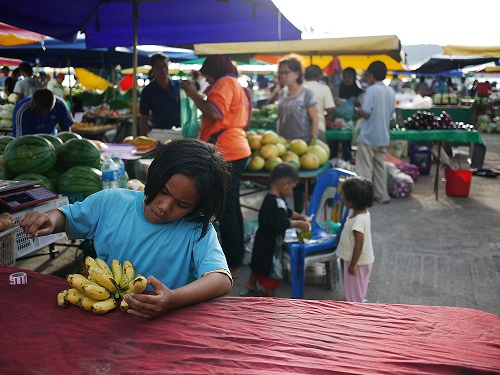

In [ ]:
from IPython.display import Image
Image(url)

# Keywords extractor

## Cleaning

In [ ]:
# Initialize the MorphAnalyzer and load the Russian stop words
morph = MorphAnalyzer(lang='ru')
stop_words = set(stopwords.words("russian"))

def normalize_and_remove_stop_words(text):
    # Tokenize the text
    words = word_tokenize(text, language="russian")
    
    # Lemmatize and remove stop words
    normalized_words = []
    for word in words:
        parsed_word = morph.parse(word)[0]
        lemma = parsed_word.normal_form
        if lemma not in stop_words:
            normalized_words.append(lemma)
    
    # Combine the normalized words into a single string
    normalized_text = ' '.join(normalized_words)

    # normalized_text = 
    
    return normalized_text

# Example usage
text = "Был солнечный день, и птицы пели весело на ветках."
normalized_text = normalize_and_remove_stop_words(text)
print(normalized_text)


солнечный день , птица петь весело ветка .


##Keywords2text generator

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

path = 'AnyaSchen/rugpt3-mayak-keywords'
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path)

In [ ]:
def generate_poetry(input: str, model, num_beams=3):
  input = input if len(input) > 0 else tokenizer.bos_token #токен начала предложения
  input_ids = tokenizer.encode(input, return_tensors="pt").to(device)
  # Create an attention mask
  attention_mask = (input_ids != tokenizer.pad_token_id).float()

    # Set the pad_token_id
  tokenizer.pad_token_id = tokenizer.eos_token_id
  with torch.no_grad():
        out = model.generate(input_ids,
                            do_sample=True,
                            num_beams=num_beams,
                            temperature=2.0,
                            top_p=0.9,
                            max_length = 200,
                            # stopping_criteria=StoppingCriteriaList([stop_criteria]),
                            eos_token_id=tokenizer.eos_token_id,
                            bos_token_id=tokenizer.bos_token_id,
                            attention_mask=attention_mask
                            ).to(device)
  return tokenizer.batch_decode(out, skip_special_tokens=True)[0]

In [ ]:
inp = f'''Автор: Тютчев
Ключевые слова: {', '.join(keywords)}'''

In [ ]:
print(generate_poetry(inp, model))

Setting `pad_token_id` to `eos_token_id`:50259 for open-end generation.


Автор: Тютчев
Ключевые слова: сон, любовь, тайна, гореть, холодный
Поэзия: О, не будь же ты холодным и чужим,
Постой среди чужих, внемли их тайнам,
О, светлейший, ты им нужен, ты нужен им,
Дай жизни мне! Дай мне вздохнуть, вздохнуть в тиши!
Постой, дай мне внемлеть их голосам!
Всю жизнь, все жизни отдал бы я за эти речи,
Какими бы странными, странными тайнами
Ты ни был бы окружен, сколько бы ни было, —
Когда ж, когда же ты вернешься?
Ты, мой друг, не можешь, ты не можешь, не смеешь
Тебе не верить и не любить меня.
И если уж не любишь, так это — из-за них,
Из-за них — и не можешь ты мне простить!..

